In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-machine-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=8813e12e80c84063861a049d1712bf0dca42766df8d672a98acd01b607e928c3
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

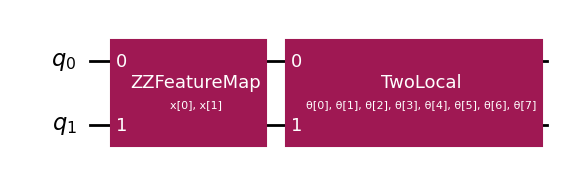

In [ ]:
num_inputs = 2
feature_map = ZZFeatureMap(num_inputs,reps =1)
ansatz = TwoLocal(2, ['ry','rz'], 'cz', 'linear', reps = 1)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_algorithms.utils import algorithm_globals

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SineDataset(Dataset):
    def __init__(self, intervals, num_points):
        self.x = []
        self.y = []

        for interval in intervals:
            start, end = interval
            x_interval = np.round(np.linspace(start, end, num_points, endpoint=False),4)
            y_interval = np.round(np.sin(x_interval),4)

            self.x.append(x_interval)
            self.y.append(y_interval)

        self.x = np.concatenate(self.x)
        self.y = np.concatenate(self.y)

        self.x = torch.tensor(self.x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Define the intervals
intervals = [
    (0, np.pi/4),
    (np.pi/4, np.pi/2),
    (np.pi/2, 3*np.pi/4),
    (3*np.pi/4, np.pi),
    (np.pi, 5*np.pi/4),
    (5*np.pi/4, 3*np.pi/2),
    (3*np.pi/2, 7*np.pi/4),
    (7*np.pi/4, (2*np.pi+0.02))
]

# Number of points in each interval
num_points = 200

In [ ]:
class HybridQNN(nn.Module):
  def __init__(self):
    super(HybridQNN, self).__init__()
    qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters,input_gradients=True)
    initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
    self.layer1 = nn.Linear(1, 10)
    self.layer2 = nn.Linear(10, 2)
    self.qnn = TorchConnector(qnn, initial_weights=initial_weights)
    self.final_layer = nn.Linear(2, 1)
  def forward(self, x):
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = self.qnn(x)
    # x = torch.sigmoid(self.final_layer(x))
    return x


In [ ]:
# num_points = 100
dataset = SineDataset(intervals, num_points)
dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

In [ ]:
model = HybridQNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0024
Epoch [20/100], Loss: 0.0016
Epoch [30/100], Loss: 0.0010
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0006


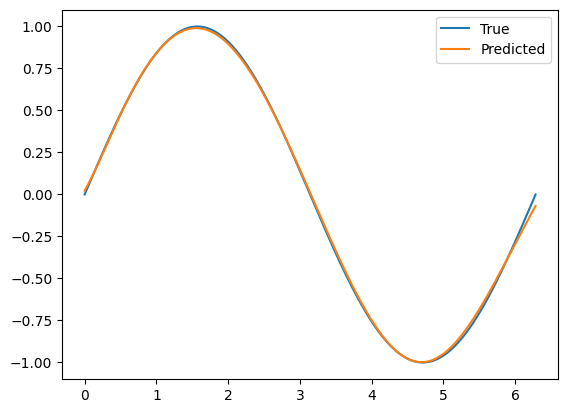

In [ ]:
# Evaluate the model
model.eval()
x_test = torch.tensor(np.linspace(0, 2 * np.pi, 400), dtype=torch.float32).unsqueeze(1)
y_test = torch.sin(x_test)
y_pred = model(x_test).detach().numpy()

# Plot the results
plt.plot(x_test.numpy(), y_test.numpy(), label='True')
plt.plot(x_test.numpy(), y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

y_test_np = y_test.numpy()
r2 = r2_score(y_test_np, y_pred)
print(f'R-squared: {r2:.4f}')

R-squared: 0.9996


In [ ]:
# for i in range(len(dataset)):
#     x, y = dataset[i]
#     print(f"Index {i}: x = {x.item():.3f}, y = {y.item():.3f}")

In [ ]:
# for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
#     print(f"Batch {batch_idx + 1}")
#     for i in range(len(x_batch)):
#         print(f"  Index {i}: x = {x_batch[i].item():.3f}, y = {y_batch[i].item():.3f}")

In [ ]:
ask = np.linspace(0, np.pi/4, 100)

In [ ]:
random_value = np.round(np.random.uniform(0, 2 * np.pi),3)

# Convert the random value to a tensor
random_value_tensor = torch.tensor([random_value], dtype=torch.float32).unsqueeze(1)
print(random_value_tensor)
# Set the model to evaluation mode
model.eval()

# Get the model's prediction for the random value
with torch.no_grad():
    y_pred = model(random_value_tensor).item()

# Calculate the true sine value for the random value
y_true = np.round(np.sin(random_value),5)

print(f"Random Value: {random_value}")
print(f"Model Prediction: {np.round(y_pred,5)}")
print(f"True Value: {y_true}")
print(f"Difference: {np.round(y_pred-y_true,5)}")
print(f"Percentage: {(np.abs(np.round(y_pred-y_true,5))/np.abs(y_true))*100} ")

tensor([[2.8930]])
Random Value: 2.893
Model Prediction: 0.25011
True Value: 0.24604
Difference: 0.00407
Percentage: 1.654202568688018 


In [ ]:
# print(np.pi/4)

In [ ]:
1/np.sqrt(2)

0.7071067811865475